In [0]:
!pip install tqdm

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import fetch_openml
from tqdm import tqdm_notebook as tqdm
import json

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from metafeatures import Metafeatures

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GOOGLE_DRIVE_PATH_PREFIX = '/content/drive/My Drive/AutoML/'

In [0]:
mse_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Regression/mse.csv'
r2_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Regression/r2.csv'
mae_df_path = GOOGLE_DRIVE_PATH_PREFIX + 'data/Metrics/Regression/mae.csv'
mse_df = pd.read_csv(mse_df_path, index_col=[0])
r2_df = pd.read_csv(r2_df_path, index_col=[0])
mae_df = pd.read_csv(mae_df_path, index_col=[0])

In [0]:
mae_df

,8,189,191,194,195,196,197,198,200,201,204,207,216,223,225,227,231,287,294,296,298,299,301,308,315,344,434,482,500,503,504,509,511,512,520,522,524,529,531,534,536,540,547,549,550,555,557,558,562,567,572,573,574,664,666,676,688,690,703,709,712,1027,1028,1097,1245,23395,494,519,560,1030
663,-18.215962,-2.702020,-2.979583,-6.843745,-31.085819,-7.393667,-8.295277,-23.616000,-6.749734,NaN,-21.135935,-38.083948,NaN,-8.326437,-6.450776,-7.957722,-10.165836,-7.660828,-5.795339,-8.519589,-37.635425,NaN,-34.883848,-2.093028,-2.093028,-0.791544,NaN,-1.595609,-3.454787,NaN,-10.903325,-1.254124,-24.891211,-0.706145,-1.697306,-8.487581,-18.481920,-5.258511,-1.668600,-36.325321,-1.176243,NaN,-16.935204,-19.680491,-5.363867,NaN,NaN,-18.126285,-8.519589,NaN,-8.519589,-6.706817,-3.844183,-4.961443,-1.609544,-6.838306e+00,-4.037203,-10.089609,-12.216303,-32.991667,-9.871948,-39.537291,NaN,NaN,NaN,-8.352282,NaN,NaN,NaN,NaN
535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4155.226154,-3668.508914,NaN,NaN,NaN,NaN,NaN,-4924.543990,-4438.846402,NaN,NaN,NaN,-4925.028004,NaN,NaN,-3510.836630,-4633.939091,NaN,NaN,NaN,NaN,-5364.700707,-5255.975000,NaN,NaN,-4319.625797,NaN,NaN,NaN,NaN,NaN,NaN,-3097.815289,NaN,-3835.293878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.610140,-0.697053,NaN,NaN,NaN,NaN,NaN,-0.603744,NaN,NaN,NaN,NaN,-0.558808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.643198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.671995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,-2.297525,-2.549031,-2.530691,-2.737852,-2.519242,-2.697229,-2.492086,-2.552755,-2.240639,NaN,-2.972365,-2.651619,NaN,-2.654984,-2.491461,-2.588966,-2.646628,-2.699031,-2.469703,-2.505750,-2.745643,NaN,-2.778683,-2.748333,-2.748333,-5.332819,NaN,-2.325460,-2.880121,NaN,-3.350354,-2.302419,-2.449766,-6.450778,-3.045810,-2.479800,-2.647944,-2.376483,-2.313639,-2.325087,-2.351314,-2.279220,-2.351194,-2.986315,-2.553125,-2.832502,-2.897984,-2.404395,-2.505750,NaN,-2.491485,-2.279031,-2.488474,-2.336423,-2.259613,-2.385552e+00,-3.034125,-2.739923,-2.463660,-2.520356,-2.556453,-2.612209,NaN,NaN,NaN,-2.625960,NaN,-3.221947,NaN,NaN
528,-0.242052,-0.108844,-0.136971,-0.119362,NaN,-0.118726,-0.115740,-0.124887,-0.114278,NaN,-0.242052,-0.127303,NaN,-0.128646,-0.114170,-0.117105,-0.120954,-0.116546,-0.120352,-0.115175,-0.185706,NaN,-0.185083,-0.133167,-0.133167,-0.109493,NaN,-0.110725,-0.135314,NaN,-0.118805,-0.107934,-0.138764,-0.111536,-0.109938,-0.115707,-0.241773,-0.114164,-0.108095,-0.116542,-0.108859,NaN,-0.131305,-0.242052,-0.132045,NaN,NaN,-0.241837,-0.115175,NaN,-0.115740,-0.114164,-0.114444,-0.115437,-0.111838,-1.140039e-01,-0.145468,-0.115113,-0.117816,-0.136885,-0.115561,NaN,NaN,NaN,NaN,-0.120511,NaN,-0.136572,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23397,NaN,NaN,NaN,NaN,NaN,-0.010024,-0.010126,-0.018698,-0.035716,NaN,NaN,NaN,NaN,NaN,NaN,-0.010397,NaN,NaN,NaN,-0.010021,-0.030500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.028629,NaN,NaN,NaN,-0.033069,NaN,NaN,-0.010449,NaN,NaN,NaN,NaN,NaN,-0.032690,-0.015557,NaN,NaN,NaN,-0.024904,NaN,-0.010021,NaN,-0.010038,NaN,NaN,NaN,NaN,-2.781781e+14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009563,NaN,NaN,NaN,NaN
1204,NaN,NaN,NaN,NaN,NaN,NaN,-0.567197,NaN,-0.612270,NaN,NaN,NaN,NaN,NaN,NaN,-0.564107,NaN,NaN,NaN,-0.566473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.742441,NaN,NaN,NaN,-0.6

### Calculate all KPIs

In [0]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [0]:
def get_kpis_for_dataset(dataset_id):
  mfs_dump_path = '/content/drive/My Drive/AutoML/kpis/Regression_'
  mfs_path = '{}/{}.json'.format(mfs_dump_path, dataset_id)
  try:
    with open(mfs_path, 'r') as f:
      mfs = json.load(f)
    return mfs
  except FileNotFoundError:
    # calculate kpis for this dataset
    data, target = fetch_openml(data_id=dataset_id, return_X_y=True, as_frame=True)
    mf = Metafeatures(data, target, task='regression')
    mfs = mf.compute()
    with open(mfs_path, 'w') as f:
      json.dump(mfs, f, indent=4, cls=NumpyEncoder)
    return mfs


### Generate dataset

In [0]:
kpis_df = pd.DataFrame()

In [0]:
rows_loop = tqdm(mae_df.iterrows(), total=mae_df.shape[0])
for test_ind, row in rows_loop:
  # get KPIs of dataset
  # rename columns (add test__ prefix)
  test_mfs = get_kpis_for_dataset(test_ind)
  test_mfs = {'test__'+k: v for k, v in test_mfs.items()}

  columns_loop = tqdm(row.items(), total=row.shape[0])

  for ref_ind, mae in columns_loop:
    if not np.isnan(mae) and not np.isnan(mse_df.loc[test_ind, str(ref_ind)]) and not np.isnan(r2_df.loc[test_ind, str(ref_ind)]):
      try:
        ref_mfs = get_kpis_for_dataset(ref_ind)
        ref_mfs = {'ref__'+k: v for k, v in ref_mfs.items()}
        all_mfs = {**ref_mfs, **test_mfs}
        all_mfs['PIPELINE_MAE'] = mae
        all_mfs['PIPELINE_MSE'] = mse_df.loc[test_ind, str(ref_ind)]
        all_mfs['PIPELINE_R2'] = r2_df.loc[test_ind, str(ref_ind)]

        kpis_df = kpis_df.append(pd.Series(all_mfs, name='{}_{}'.format(test_ind, ref_ind)))
      except Exception as e:
        print(e)
        continue

In [0]:
kpis_df = kpis_df.replace([np.inf, -np.inf], np.nan)
kpis_df['PIPELINE_MSE'] *= -1.0
kpis_df['PIPELINE_MAE'] *= -1.0

In [0]:
kpis_df

,PIPELINE_MAE,PIPELINE_MSE,PIPELINE_R2,ref__dataset_dimensionality,ref__dataset_ratio,ref__decision_tree_1_mae,ref__decision_tree_1_mse,ref__decision_tree_1_r2,ref__decision_tree_3_mae,ref__decision_tree_3_mse,ref__decision_tree_3_r2,ref__knn_5_mae,ref__knn_5_mse,ref__knn_5_r2,ref__log_dataset_dimensionality,ref__log_nb_instances,ref__max__target,ref__max_correlation_features_target,ref__max_cov_numeric_feautures,ref__max_max_numeric_feautures,ref__max_mean_numeric_feautures,ref__max_median_numeric_feautures,ref__max_min_numeric_feautures,ref__max_stdev_numeric_feautures,ref__max_var_numeric_feautures,ref__mean__target,ref__mean_correlation_features_target,ref__mean_cov_numeric_feautures,ref__mean_max_numeric_feautures,ref__mean_mean_numeric_feautures,ref__mean_median_numeric_feautures,ref__mean_min_numeric_feautures,ref__mean_stdev_numeric_feautures,ref__mean_var_numeric_feautures,ref__median__target,ref__median_correlation_features_target,ref__median_cov_numeric_feautures,ref__median_max_numeric_feautures,ref__median_mean_numeric_feautures,ref__median_median_numeric_feautures,...,test__nb_instances,test__nb_missing_vals,test__nb_numeric_features,test__pca_1,test__pca_2,test__q1__target,test__q1_correlation_features_target,test__q1_cov_numeric_feautures,test__q1_max_numeric_feautures,test__q1_mean_numeric_feautures,test__q1_median_numeric_feautures,test__q1_min_numeric_feautures,test__q1_stdev_numeric_feautures,test__q1_var_numeric_feautures,test__q3__target,test__q3_correlation_features_target,test__q3_cov_numeric_feautures,test__q3_max_numeric_feautures,test__q3_mean_numeric_feautures,test__q3_median_numeric_feautures,test__q3_min_numeric_feautures,test__q3_stdev_numeric_feautures,test__q3_var_numeric_feautures,test__random_tree_2_mae,test__random_tree_2_mse,test__random_tree_2_r2,test__ratio_categorical_numeric_features,test__ratio_features_with_missing_vals,test__ratio_instances_with_missing_vals,test__ratio_numeric_categorical_features,test__stdev__target,test__stdev_correlation_features_target,test__stdev_cov_numeric_feautures,test__stdev_max_numeric_feautures,test__stdev_mean_numeric_feautures,test__stdev_median_numeric_feautures,test__stdev_min_numeric_feautures,test__stdev_stdev_numeric_feautures,test__stdev_var_numeric_feautures,test__pca_3
663_8,1.821596e+01,6.363209e+02,7.494265e-01,69.000000,0.014493,2.570681,1.059607e+01,0.026159,2.677672,1.317813e+01,-0.191660,2.635819,1.199964e+01,-0.121171,4.234107,5.843544,20.000000,0.341224,4.470902e+01,297.000000,90.159424,90.000000,65.000000,39.254616,1.540925e+03,3.455072,0.248227,15.677683,155.000000,50.672462,46.200001,20.400000,18.325436,475.874329,3.000000,0.279588,9.392366,138.000000,38.284058,26.000000,...,120.0,0.0,2.0,0.852459,0.147541,-88.0,0.006445,253.760502,50.000000,3.125000e+00,3.125000,-43.750000,19.482534,456.407566,-5.0,0.627675,1221.113445,50.000000,1.937500e+01,19.375000,-11.250000,29.604357,953.256298,29.686631,1414.543441,0.448312,0.0,0.0,0.0,0.0,52.194164,0.621230,967.352905,0.000000,16.250000,16.250000,32.50000,10.121822,4.968487e+02,NaN
663_189,2.702020e+00,1.348822e+01,9.947483e-01,1024.000000,0.000977,0.189293,5.370812e-02,0.226858,0.175592,4.699887e-02,0.323322,0.094963,1.479374e-02,0.786945,6.931472,9.010913,1.458521,0.239371,5.722352e-02,1.570753,0.022792,0.041346,-1.568904,0.913243,8.340123e-01,0.714284,-0.099152,-0.023595,1.570534,0.002473,0.002505,-1.570340,0.905281,0.819554,0.708822,-0.111245,-0.026555,1.570598,0.004556,-0.000336,...,120.0,0.0,2.0,0.852459,0.147541,-88.0,0.006445,253.760502,50.000000,3.125000e+00,3.125000,-43.750000,19.482534,456.407566,-5.0,0.627675,1221.113445,50.000000,1.937500e+01,19.375000,-11.250000,29.604357,953.256298,29.686631,1414.543441,0.448312,0.0,0.0,0.0,0.0,52.194164,0.621230,967.352905,0.000000,16.250000,16.250000,32.50000,10.121822,4.968487e+02,NaN
663_191,2.979583e+00,1.685395e+01,9.933537e-01,6.062500,0.164948,29.043423,1.210442e+03,-0.025023,31.467682,1.418494e+03,-0.256284,27.628635,1.133763e+03,0.015

In [0]:
kpis_df_ = kpis_df.query('PIPELINE_R2 >= -1.0')
kpis_df_ = kpis_df_.query('PIPELINE_MAE <= 2.0')
kpis_df_ = kpis_df_.query('PIPELINE_MSE <= 2.0')

In [0]:
kpis_df_

,PIPELINE_MAE,PIPELINE_MSE,PIPELINE_R2,ref__dataset_dimensionality,ref__dataset_ratio,ref__decision_tree_1_mae,ref__decision_tree_1_mse,ref__decision_tree_1_r2,ref__decision_tree_3_mae,ref__decision_tree_3_mse,ref__decision_tree_3_r2,ref__knn_5_mae,ref__knn_5_mse,ref__knn_5_r2,ref__log_dataset_dimensionality,ref__log_nb_instances,ref__max__target,ref__max_correlation_features_target,ref__max_cov_numeric_feautures,ref__max_max_numeric_feautures,ref__max_mean_numeric_feautures,ref__max_median_numeric_feautures,ref__max_min_numeric_feautures,ref__max_stdev_numeric_feautures,ref__max_var_numeric_feautures,ref__mean__target,ref__mean_correlation_features_target,ref__mean_cov_numeric_feautures,ref__mean_max_numeric_feautures,ref__mean_mean_numeric_feautures,ref__mean_median_numeric_feautures,ref__mean_min_numeric_feautures,ref__mean_stdev_numeric_feautures,ref__mean_var_numeric_feautures,ref__median__target,ref__median_correlation_features_target,ref__median_cov_numeric_feautures,ref__median_max_numeric_feautures,ref__median_mean_numeric_feautures,ref__median_median_numeric_feautures,...,test__nb_instances,test__nb_missing_vals,test__nb_numeric_features,test__pca_1,test__pca_2,test__q1__target,test__q1_correlation_features_target,test__q1_cov_numeric_feautures,test__q1_max_numeric_feautures,test__q1_mean_numeric_feautures,test__q1_median_numeric_feautures,test__q1_min_numeric_feautures,test__q1_stdev_numeric_feautures,test__q1_var_numeric_feautures,test__q3__target,test__q3_correlation_features_target,test__q3_cov_numeric_feautures,test__q3_max_numeric_feautures,test__q3_mean_numeric_feautures,test__q3_median_numeric_feautures,test__q3_min_numeric_feautures,test__q3_stdev_numeric_feautures,test__q3_var_numeric_feautures,test__random_tree_2_mae,test__random_tree_2_mse,test__random_tree_2_r2,test__ratio_categorical_numeric_features,test__ratio_features_with_missing_vals,test__ratio_instances_with_missing_vals,test__ratio_numeric_categorical_features,test__stdev__target,test__stdev_correlation_features_target,test__stdev_cov_numeric_feautures,test__stdev_max_numeric_feautures,test__stdev_mean_numeric_feautures,test__stdev_median_numeric_feautures,test__stdev_min_numeric_feautures,test__stdev_stdev_numeric_feautures,test__stdev_var_numeric_feautures,test__pca_3
663_344,0.791544,1.164553,0.999573,4076.800000,0.000245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.313068,10.615653,2.499780,0.737177,8.301063e+01,1.200000e+03,1.100271e+03,1.101000e+03,1000.00,115.273041,1.328787e+04,-8.856154,0.275705,14.638163,244.411285,195.937149,196.109100,147.737015,27.437454,2.399127e+03,-5.020515,0.261406,2.179092,4.999570,-0.003479,-0.026425,...,120.0,0.0,2.0,0.852459,0.147541,-88.0,0.006445,253.760502,50.000000,3.125000e+00,3.125000,-43.750000,19.482534,456.407566,-5.0,0.627675,1221.113445,50.000000,1.937500e+01,19.375000,-11.250000,29.604357,953.256298,29.686631,1414.543441,0.448312,0.0,0.0,0.0,0.0,52.194164,0.621230,967.352905,0.000000,16.250000,16.250000,32.50000,10.121822,4.968487e+02,NaN
663_512,0.706145,0.802089,0.999685,2001.000000,0.000500,0.075642,1.255356e-02,0.433542,0.054736,6.126647e-03,0.732195,0.055887,7.268014e-03,0.661734,7.601402,7.601402,0.161000,0.804894,2.122413e-02,2.360000e+00,2.095802e+00,2.140000e+00,0.58,0.173839,3.021997e-02,-0.047455,0.804894,0.021224,2.360000,2.095802,2.140000,0.580000,0.173839,3.021997e-02,0.000000,0.804894,0.021224,2.360000,2.095802,2.140000,...,120.0,0.0,2.0,0.852459,0.147541,-88.0,0.006445,253.760502,50.000000,3.125000e+00,3.125000,-43.750000,19.482534,456.407566,-5.0,0.627675,1221.113445,50.000000,1.937500e+01,19.375000,-11.250000,29.604357,953.256298,29.686631,1414.543441,0.448312,0.0,0.0,0.0,0.0,52.194164,0.621230,967.352905,0.000000,16.250000,16.250000,32.50000,10.121822,4.968487e+02,NaN
523_315,0.610140,0.978374,0.935604,15.700787,0.063691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.753711,7.597898,1.000000,0.737957,2.388095e+00,9.459700e+04,4.618834e+04,4.809000e+04,70.00,25299.726562,6.400762e+08,0.237979,0

In [0]:
kpis_df_.to_csv(GOOGLE_DRIVE_PATH_PREFIX + 'kpis_regression.csv')

#### Plotting target variables distributions

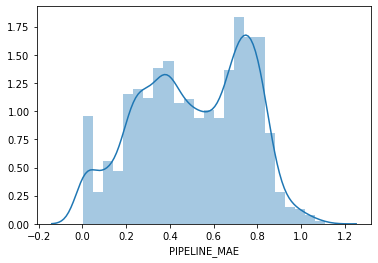

In [0]:
sns.distplot(kpis_df_['PIPELINE_MAE'])

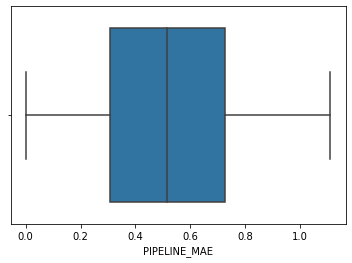

In [0]:
sns.boxplot(kpis_df_['PIPELINE_MAE'])

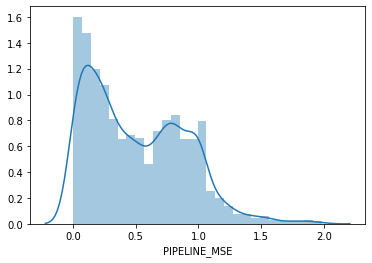

In [0]:
sns.distplot(kpis_df_['PIPELINE_MSE'])

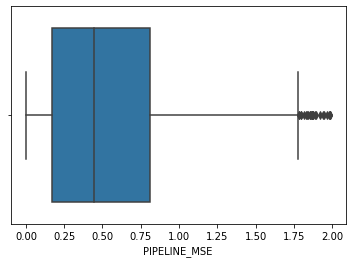

In [0]:
sns.boxplot(kpis_df_['PIPELINE_MSE'])

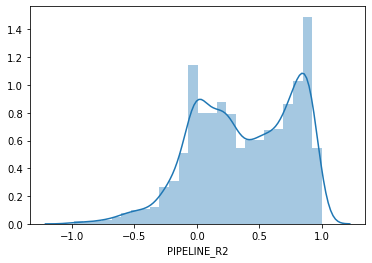

In [0]:
sns.distplot(kpis_df_['PIPELINE_R2'])

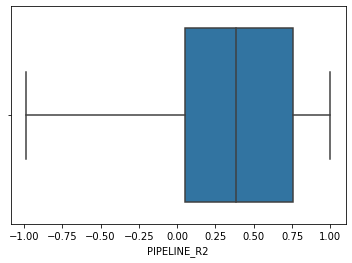

In [0]:
sns.boxplot(kpis_df_['PIPELINE_R2'])